In [55]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [56]:
data = pd.read_csv("data/0mA(29s)~30mA(1s)_DODI_C_merge.csv") #통합 데이터
data.describe()

,Voltage(V),Current(A),Resistance(Ohm),Power(W)
count,9.919349e+06,9.919349e+06,9.919349e+06,9.919349e+06
mean,3.807341e+00,9.882173e-04,1.731465e+04,3.441465e-03
std,1.406956e-01,5.084169e-03,6.363919e+04,1.747519e-02
min,1.680000e-02,-1.500000e-03,0.000000e+00,0.000000e+00
25%,3.641800e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.883500e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.894900e+00,2.000000e-04,1.164848e+04,1.000000e-03
max,3.907000e+00,1.399000e+00,6.489843e+05,1.340000e-01


### 데이터 자르기 (time, volt, current)

In [57]:
data = data.iloc[:, :3] #.values

In [58]:
data.head()

,Time,Voltage(V),Current(A)
0,2021-09-24 오후 4:28:15,0.0169,0.0000
1,2021-09-24 오후 4:28:15,0.0169,0.0000
2,2021-09-24 오후 4:28:15,0.0169,0.0000
3,2021-09-24 오후 4:28:15,0.0169,1.3990
4,2021-09-24 오후 4:28:16,0.0168,1.3963


### 기준 전압 인덱스 구하기
#### 통신 전류가 시작하는 곳의 직전 인덱스를 기준 전압으로 하였으나 기준이 애매하여 기준을 변경
- 전압이 낮아지는 곳이 통신이 시작하는 부분

In [59]:
comm_A = np.where(data['Current(A)'] > 0.020) #통신 전류

In [60]:
# 전압이 2V 이하인 통신 전류 데이터 인덱스가 있는 경우
if np.where(data['Voltage(V)'] < 2.000):
    print("true")
    comm_V_ = np.where(data['Voltage(V)'] < 2.000) #2v가 넘는 곳의 인덱스
    comm_V = np.array(comm_V_[0])
    comm_ = comm_A

    for i in comm_V:
        comm_ = np.delete(comm_, np.where(comm_ == i))

# 전압이 2V 이하인 통신 전류 데이터 인덱스가 없는 경우
else:
    print("false")
    comm_ = np.array(comm_A[0]) #comm_A[0]의 type이 tuple이기 때문에 numpy array로 변환
    comm_ = np.array(comm_[0])

true


#### 통신 전류 시작 인덱스 하나만

In [61]:
#첫 번째 인덱스는 넣어두고 시작
comm = np.array(comm_[0])

for idx in range(int(len(comm_))-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_[idx]+1 != comm_[idx+1]:
        comm = np.append(comm, comm_[idx+1])

In [62]:
comm

array([    132,     268,     401, ..., 9919203, 9919266, 9919330],
      dtype=int64)

#### 임시 기준 전압(t)은 통신 시작 전류 인덱스 바로 전

In [63]:
t_crit = comm - 1

In [64]:
t_crit.shape

(116508,)

#### 전압이 떨어지기 전의 전압값의 인덱스를 찾아야 함
    - 여기서 인덱스를 잘 골라내야 함!!
    - 전압이 감소하면서 전류가 증가하는 부분이 통신 구간의 시작이다
    - 기존  > 0.020으로 한 경우에는 한 번의 통신에 인덱스가 더 추가된 부분이 있을 수 있음
        - 한 번 더 처리를 한 후에 같은 값(인덱스)가 있으면 제거 (중복 제거)
$ \therefore\; > 0.020 $ 인 부분이면서 전압이 (-), 전류가 (+)인 부분이 최종 통신 시작 인덱스!!

#### 통신 전류가 시작하는 곳의 전압값과 이전 인덱스의 전압값을 비교하여 이전 인덱스의 전압값이 더 크다면 기준 전압으로 하고 그렇지 않다면 기준 전압으로 하지 않는다
1. $> 0.020$ 을 통신 전류로 하여 임시 기준 전압 인덱스를 찾는다
2. 임시 기준 전압값(t)과 그 이전 전압값(t-1)을 비교한다.
3. 이전 전압값(t-1)이 임시 기준 전압값(t)보다 크다면 그 값이 기준 전압값!
4. 같다면 임시 기준 전압값(t)과 전전 전압값(t-2)를 비교
5. 반복


In [65]:
ref = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t  #tmp는 >0.020 이전의 전압 인덱스
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else:
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref = np.append(ref, tmp)
            
ref = np.unique(ref) #중복 값 제거

100%|████████████████████████████████████████████████████████████████████████| 116508/116508 [00:26<00:00, 4458.10it/s]


In [66]:
ref.shape

(116506,)

### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [67]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
index = np.zeros((1,2))

crit = 0.50

for _, i in enumerate(tqdm(ref)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    for j in range(1, 150):
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j]) / data['Voltage(V)'][i] * 100 #(기준전압 - 현재전압)/기준전압 *100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][i+j]])) #배열에 현재 전압값 추가

        #회복 전압이면 반복을 멈추고 각 배열에 요소 추가
        #(data['Voltage(V)'][i+j] > 2.0) and -> 잘못된 데이터가 들어가 있었음
        # 1. 현재 전압 < 다음 전압 && 2. 다음 전류가 0.020보다 작을 때 && 3. 현재 전압 변화율 <= 기준 전압 변화율 && 4. 전압 변화율 != 0
        if (data['Voltage(V)'][i+j] < data['Voltage(V)'][i+j+1]) and (data['Current(A)'][i+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            #전압 변화율 추가(최대 전압 변화율(최저 전압), 현재 전압 변화율)
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            
            #전압 회복 시간(기준 전압 시간, 회복 전압 시간)
            recovery_time = np.append(recovery_time, np.array([data['Time'][i], data['Time'][i+j]]).reshape(1,2), axis=0)
            
            #전압(기준 전압, 최저 전압, 회복 전압)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j]]).reshape(1,3), axis=0)

            index = np.append(index, np.array([i, (i+j)]).reshape(1,2), axis=0)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)
index = np.delete(index, 0, 0)

100%|█████████████████████████████████████████████████████████████████████████| 116506/116506 [13:24<00:00, 144.80it/s]


### 시간을 timedelt로 변환하기 위함
- 전압 회복 시간을 알기 위해서 전체 시간을 변환

In [68]:
date_=[] #replace korean to english

for i in recovery_time.flatten():
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)
    
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))
    
date___=[] #switch index

for i in date__: #위치 변경
    tmp = i[1] 
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)
    
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)
    
recovery_time = np.array(parsing_date).reshape(recovery_time.shape[0], 2)

100%|███████████████████████████████████████████████████████████████████████| 233012/233012 [00:22<00:00, 10354.83it/s]


### 그래프를 그려 변화 확인
#### 통신시에 전압을 얼마나 사용하는지 볼 수 있음

#### 통신 데이터 전압 사용 그래프

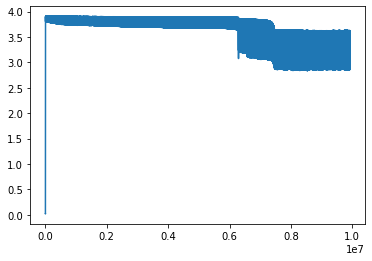

In [69]:
plt.plot(data['Voltage(V)'])

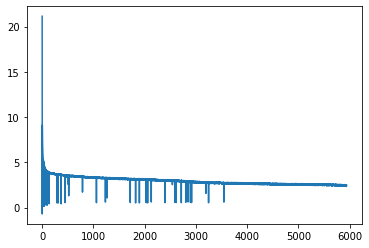

In [41]:
plt.plot(np.max(recovery_rate[:], axis=1)) #dodi_c(merge: 데이터 제거)

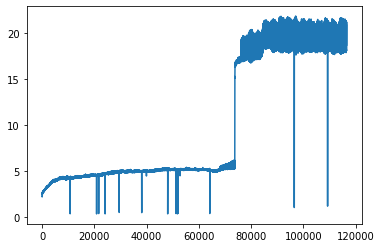

In [70]:
plt.plot(np.max(recovery_rate[:], axis=1)) #dodi_c(merge: 데이터 제거)

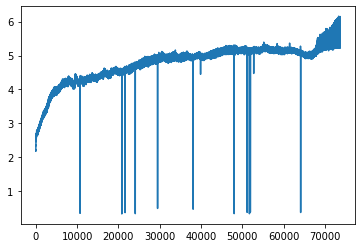

In [71]:
plt.plot(np.max(recovery_rate[:73724], axis=1)) #전압 떨어지기 전

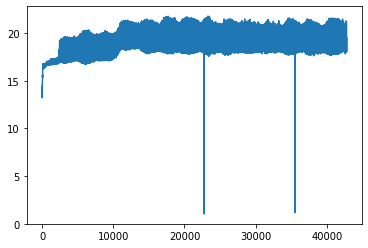

In [72]:
plt.plot(np.max(recovery_rate[73724:], axis=1)) #전압이 떨어지고 난 후 

In [73]:
max_rate = np.max(recovery_rate[:], axis=1)

In [74]:
len(max_rate[:73724])

73724

### 데이터 분리해서 저장(데이터 보내드리기)
#### 1. 전체 전압 변화율 데이터

In [75]:
f = open("dodi_rate_whole.csv", "w")
f.write("max_rate\n")

for i in range(int(len(max_rate))):
    f.write(str(max_rate[i]) + "\n")
    
f.close()

#### 2. 전압 떨어지기 전 변화율

In [76]:
f = open("dodi_rate_before.csv", "w")
f.write("max_rate\n")

for i in range(int(len(max_rate[:73724]))):
    f.write(str(max_rate[i]) + "\n")
    
f.close()

#### 3. 전압이 떨어진 후 변화율

In [77]:
f = open("dodi_rate_after.csv", "w")
f.write("max_rate\n")

for i in max_rate[73724:]:
    f.write(str(i) + "\n")
    
f.close()

#### 전압 변화율이 치솟는 부분

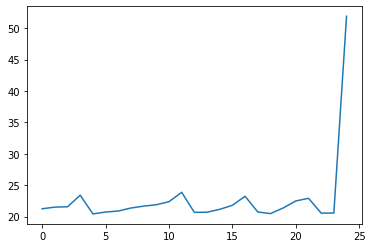

In [32]:
plt.plot(np.max(recovery_rate[73700:73725], axis=1)) #dodi_c(merge)

In [33]:
index[73724]

array([6293063., 6293077.])

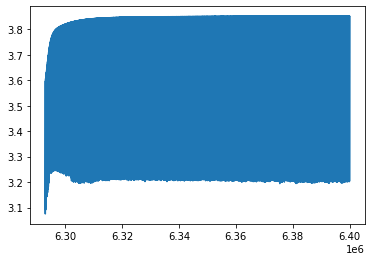

In [42]:
plt.plot(data['Voltage(V)'][6293063:6400000])

In [82]:
np.argmax(np.max(recovery_rate[73700:73725], axis=1))

24

In [73]:
recovery_time[73724]

array([datetime.datetime(2021, 10, 20, 15, 4, 55),
       datetime.datetime(2021, 10, 20, 15, 4, 58)], dtype=object)

In [74]:
recovery_volt[73724]

array([3.594 , 3.075 , 3.5895])

In [76]:
recovery_rate[73724]

array([51.9 ,  0.45])

#### 초반

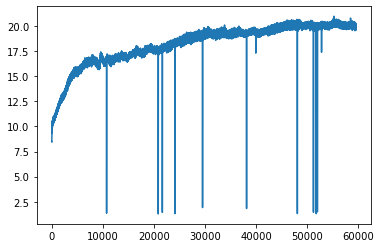

In [45]:
plt.plot(np.max(recovery_rate[:], axis=1)) #dodi_c(1)

In [1063]:
recovery_time[51748]

array([datetime.datetime(2021, 10, 12, 16, 7, 25),
       datetime.datetime(2021, 10, 12, 16, 7, 28)], dtype=object)

In [1064]:
recovery_volt[51748]

array([3.8877, 3.8746, 3.8829])

In [886]:
(recovery_volt[26080][0] - recovery_volt[26080][2]) * 100

0.45999999999999375

In [1062]:
np.argmin(np.max(recovery_rate[51700:52000], axis=1))

48

#### 시간은 timedelt형으로 되어 있기 때문에 회복 시간을 보기 위해서는 처리가 필요

In [66]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

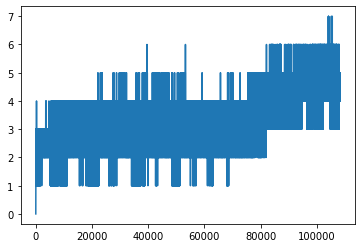

In [67]:
plt.plot(re_time)

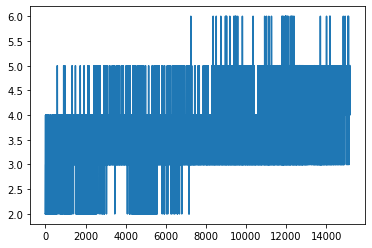

In [69]:
plt.plot(re_time[74824:90000])

In [54]:
index[74824:]

array([[6424899., 6424909.],
       [6425015., 6425025.],
       [6425129., 6425138.],
       ...,
       [9366675., 9366685.],
       [9366746., 9366756.],
       [9366818., 9366828.]])

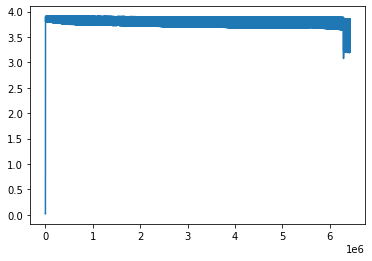

In [55]:
plt.plot(data['Voltage(V)'][:6424899])

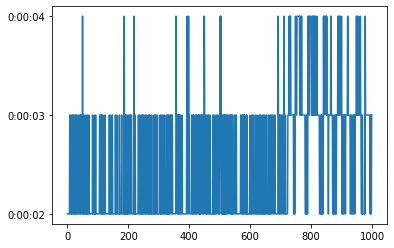

In [81]:
plt.plot(re_time[73000:74000])

#### 통신 전, 통신 중, 회복 전압 그래프

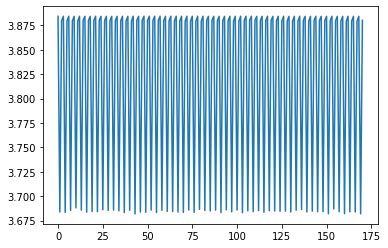

In [1074]:
plt.plot(recovery_volt[59500:].flatten())

### csv 파일 저장하기 -> ['data_index', max_rate', 'recovery_time']

In [68]:
f = open("dodi_result.csv", "w")
f.write("data_index, max_rate, recovery_time\n")

for i in range(int(len(re_time))):
    f.write(str(index[i][0]) + "," + str(max_rate[i]) + "," + str(re_time[i]) + "\n")
    
f.close()